# Data Loading

### Install required libraries

In [1]:
! pip install hazm
! pip install clean-text[gpl]==0.4.0

     |████████████████████████████████| 316 kB 7.8 MB/s 
     |████████████████████████████████| 1.4 MB 45.4 MB/s 
     |████████████████████████████████| 233 kB 68.2 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394485 sha256=8b3ebc3cc798060e56e70840c6efc0050444c10ca65b508e7becaeb16a0d391d
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154612 sha256=2bde738059826d8123ee612cefa6c14e3c9534667093620146e55d069b378e22
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 170 kB 6.9 MB/s 
     |████████████████████████████████| 64 kB 3.6 MB/s 
     |██

### Import Libraries

In [2]:
import pandas as pd
import numpy as np

import hazm
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Data Path

In [3]:
PATH = 'data/'
PATH = PATH.rstrip('/')

### Load Data into Dataframe

In [5]:
# Train
df_train = pd.read_csv(PATH + '/train.csv')
df_train.columns = ['index', 'comment', 'rate']

# Evaluation
df_eval = pd.read_csv(PATH + '/eval.csv')
df_eval.columns = ['index', 'comment', 'rate']

# Test
df_test = pd.read_csv(PATH + '/test.csv')
df_test.columns = ['index', 'comment', 'rate']

### Data Info

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    800 non-null    int64  
 1   comment  800 non-null    object 
 2   rate     800 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 18.9+ KB


In [7]:
df_train['rate'].describe()

count    800.000000
mean       0.278625
std        0.712302
min       -1.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: rate, dtype: float64

### Comment rating distribution

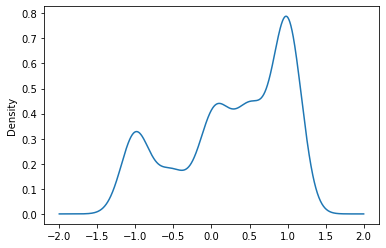

In [8]:
df_train['rate'].plot.kde()

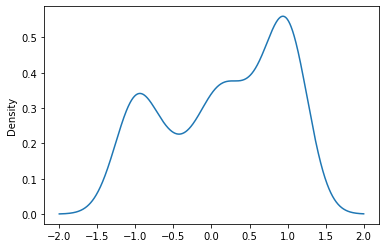

In [9]:
df_test['rate'].plot.kde()

## Cleaning Data

**Example Document to demonstrate cleaning procedure effects**

In [10]:
example_id = 789

In [11]:
example = df_train['comment'][example_id]
example

'در ضمن کيفيت بسيار بالايي هم داره هم از لحاظ صدا هم دوربين.'

#### Normalizer

In [12]:
normalizer = hazm.Normalizer()
df_train['clean_comment'] = df_train['comment'].apply(lambda comment:normalizer.normalize(comment))
df_eval['clean_comment'] = df_eval['comment'].apply(lambda comment:normalizer.normalize(comment))
df_test['clean_comment'] = df_test['comment'].apply(lambda comment:normalizer.normalize(comment))

**After Normalization**

In [13]:
example = df_train['comment'][example_id]
example

'در ضمن کيفيت بسيار بالايي هم داره هم از لحاظ صدا هم دوربين.'

#### CleanText

In [14]:
from cleantext import clean

In [15]:
clean_comment = lambda comment: clean(comment, 
                                      fix_unicode=True,
                                      to_ascii=False,
                                      lower=True,
                                      no_line_breaks=True,
                                      no_urls=True,
                                      no_emails=True,
                                      no_phone_numbers=True,
                                      no_numbers=False,
                                      no_digits=False,
                                      no_currency_symbols=True,
                                      no_punct=False)

In [16]:
df_train['clean_comment'] = df_train['comment'].apply(lambda comment:clean_comment(comment))
df_eval['clean_comment'] = df_eval['comment'].apply(lambda comment:clean_comment(comment))
df_test['clean_comment'] = df_test['comment'].apply(lambda comment:clean_comment(comment))

In [17]:
example = df_train['clean_comment'][example_id]
example

'در ضمن کيفيت بسيار بالايي هم داره هم از لحاظ صدا هم دوربين.'

#### Tokenize with Hazm

In [18]:
df_train['clean_comment'] = df_train['comment'].apply(lambda comment:hazm.word_tokenize(comment))
df_eval['clean_comment'] = df_eval['comment'].apply(lambda comment:hazm.word_tokenize(comment))
df_test['clean_comment'] = df_test['comment'].apply(lambda comment:hazm.word_tokenize(comment))

In [19]:
example = df_train['clean_comment'][example_id]
example

['در',
 'ضمن',
 'کيفيت',
 'بسيار',
 'بالايي',
 'هم',
 'داره',
 'هم',
 'از',
 'لحاظ',
 'صدا',
 'هم',
 'دوربين',
 '.']

#### Remove Symbols

In [20]:
symbol_patterns = r"(\d|\"|'ٍ|¬|[؛“،,”‘۔’’‘–]|[|\.÷+\:\-\?»\=\{}\*«»_…\؟!/ـ]|[۰'ٓ۫'ٔ]|[ٓٔ]|[ًٌٍْﹼ،َُِّ«ٰ»ٖء])"
symbol_regex = re.compile(symbol_patterns).pattern

Lambda function to remove unwanted symbols from comment

In [21]:
clean_symbols = lambda comment:[word for word in comment if re.sub(symbol_regex, "", word)!=""]

In [22]:
df_train['clean_comment'] = df_train['clean_comment'].apply(lambda comment:clean_symbols(comment))
df_eval['clean_comment'] = df_eval['clean_comment'].apply(lambda comment:clean_symbols(comment))
df_test['clean_comment'] = df_test['clean_comment'].apply(lambda comment:clean_symbols(comment))

In [23]:
example = df_train['clean_comment'][example_id]
example

['در',
 'ضمن',
 'کيفيت',
 'بسيار',
 'بالايي',
 'هم',
 'داره',
 'هم',
 'از',
 'لحاظ',
 'صدا',
 'هم',
 'دوربين']

#### Remove Wierd Symbols

In [24]:
# removing wierd patterns
wierd_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u'\U00010000-\U0010ffff'
    u"\u200d"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\u3030"
    u"\ufe0f"
    u"\u2069"
    u"\u2066"
    u"\u200c"
    u"\u2068"
    u"\u2067"
    "]+", flags=re.UNICODE)
    
wierd_regex = re.compile(wierd_pattern).pattern

Lambda function to remove wierd patterns from comment

In [25]:
clean_wierds = lambda comment:[word for word in comment if re.sub(wierd_regex, "", word)!=""]

In [26]:
df_train['clean_comment'] = df_train['clean_comment'].apply(lambda comment:clean_symbols(comment))
df_eval['clean_comment'] = df_eval['clean_comment'].apply(lambda comment:clean_symbols(comment))
df_test['clean_comment'] = df_test['clean_comment'].apply(lambda comment:clean_symbols(comment))

In [27]:
example = df_train['clean_comment'][example_id]
example

['در',
 'ضمن',
 'کيفيت',
 'بسيار',
 'بالايي',
 'هم',
 'داره',
 'هم',
 'از',
 'لحاظ',
 'صدا',
 'هم',
 'دوربين']

#### Remove Unwanted Spaces

In [28]:
space_regex = re.compile(r"\u200c|\r|\n")

Lambda function to remove half spaces from comment

In [29]:
clean_spaces = lambda comment:[re.sub(space_regex, "", word) for word in comment if re.sub(space_regex, "", word)!=""]

In [30]:
df_train['clean_comment'] = df_train['clean_comment'].apply(lambda comment:clean_spaces(comment))
df_eval['clean_comment'] = df_eval['clean_comment'].apply(lambda comment:clean_spaces(comment))
df_test['clean_comment'] = df_test['clean_comment'].apply(lambda comment:clean_spaces(comment))

In [31]:
example = df_train['clean_comment'][example_id]
example

['در',
 'ضمن',
 'کيفيت',
 'بسيار',
 'بالايي',
 'هم',
 'داره',
 'هم',
 'از',
 'لحاظ',
 'صدا',
 'هم',
 'دوربين']

#### Remove Stopwords

In [32]:
stopwords = hazm.utils.stopwords_list()
stop_pattern = r"\b(?:" + "|".join(map(re.escape, stopwords)) + r")\b"
stop_regex = re.compile(stop_pattern).pattern

Lambda function to remove stopwords from comment

In [33]:
clean_stopwords = lambda comment:[word for word in comment if re.sub(stop_regex, "", word)!=""]

In [34]:
df_train['no_stopwords_comment'] = df_train['clean_comment'].apply(lambda comment:clean_stopwords(comment))
df_eval['no_stopwords_comment'] = df_eval['clean_comment'].apply(lambda comment:clean_stopwords(comment))
df_test['no_stopwords_comment'] = df_test['clean_comment'].apply(lambda comment:clean_stopwords(comment))

In [35]:
example = df_train['no_stopwords_comment'][example_id]
example

['کيفيت', 'بسيار', 'بالايي', 'داره', 'صدا', 'دوربين']

#### Remove English Tokens

In [36]:
english_words_pattern = r"[A-Za-z]"
english_words_regex = re.compile(english_words_pattern).pattern

In [37]:
clean_english_words = lambda comment:[re.sub(english_words_regex, "", word) for word in comment if re.sub(english_words_regex, "", word)!=""]

In [38]:
df_train['no_enligh_comment'] = df_train['clean_comment'].apply(lambda comment:clean_english_words(comment))
df_eval['no_enligh_comment'] = df_eval['clean_comment'].apply(lambda comment:clean_english_words(comment))
df_test['no_enligh_comment'] = df_test['clean_comment'].apply(lambda comment:clean_english_words(comment))

In [39]:
example = df_train['no_enligh_comment'][example_id]
example

['در',
 'ضمن',
 'کيفيت',
 'بسيار',
 'بالايي',
 'هم',
 'داره',
 'هم',
 'از',
 'لحاظ',
 'صدا',
 'هم',
 'دوربين']

#### Stemming

In [40]:
stem = hazm.Stemmer().stem
clean_stem = lambda comment:[stem(word) for word in comment]

In [41]:
df_train['stemmed_version'] = df_train['clean_comment'].apply(lambda comment:clean_stem(comment))
df_eval['stemmed_version'] = df_eval['clean_comment'].apply(lambda comment:clean_stem(comment))
df_test['stemmed_version'] = df_test['clean_comment'].apply(lambda comment:clean_stem(comment))

In [42]:
example = df_train['stemmed_version'][example_id]
example

['در',
 'ضمن',
 'کيفي',
 'بسيار',
 'بالايي',
 'ه',
 'داره',
 'ه',
 'از',
 'لحاظ',
 'صدا',
 'ه',
 'دوربين']

#### Lemmatizing

In [43]:
lemmatize = hazm.Lemmatizer().lemmatize
clean_lemmatize = lambda comment:[lemmatize(word) if '#' not in lemmatize(word) else word for word in comment]

In [44]:
df_train['lemmatized_version'] = df_train['clean_comment'].apply(lambda comment:clean_lemmatize(comment))
df_eval['lemmatized_version'] = df_eval['clean_comment'].apply(lambda comment:clean_lemmatize(comment))
df_test['lemmatized_version'] = df_test['clean_comment'].apply(lambda comment:clean_lemmatize(comment))

In [45]:
example = df_train['lemmatized_version'][example_id]
example

['در',
 'ضمن',
 'کيفيت',
 'بسيار',
 'بالايي',
 'هم',
 'داره',
 'هم',
 'از',
 'لحاظ',
 'صدا',
 'هم',
 'دوربين']

#### Delete Empty Comments

In [46]:
indices = df_train.index[df_train["clean_comment"].str.len() != 0].tolist()
df_train = df_train.iloc[indices].reset_index(drop=True)

#### Label rates

In [47]:
def rate_to_label(rate, negative_threshold=-0.2, positive_threshold=0.5):
    if rate < negative_threshold:
        return 'negative'
    elif rate > positive_threshold:
        return 'positive'
    else:
        return 'neutral'


df_train['label'] = df_train['rate'].apply(lambda t: rate_to_label(t))
df_eval['label'] = df_eval['rate'].apply(lambda t: rate_to_label(t))
df_test['label'] = df_test['rate'].apply(lambda t: rate_to_label(t))

### More about comments

In [48]:
min_max_len = df_train["clean_comment"].str.len().min(), df_train["clean_comment"].str.len().max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 1 	Max: 675


#### Comments Length Distribution After Cleaning

In [49]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_train["clean_comment"].str.len()
))

fig.update_layout(
    title_text='Distribution of word counts within comments',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

#### Comments Length Distribution After Cleaning

In [50]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_train["comment"].str.len()
))

fig.update_layout(
    title_text='Distribution of word counts within comments',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### Unbalanced Data

In [51]:
fig = go.Figure()

groupby_label = df_train.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### Balance Data

In [52]:
negative_data = df_train[df_train['label'] == 'negative']
positive_data = df_train[df_train['label'] == 'positive']

cutting_point = min(len(negative_data), len(positive_data))

if cutting_point <= len(negative_data):
    negative_data = negative_data.sample(n=cutting_point).reset_index(drop=True)

if cutting_point <= len(positive_data):
    positive_data = positive_data.sample(n=cutting_point).reset_index(drop=True)

balanced_data = pd.concat([negative_data, positive_data])
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 370 non-null    int64  
 1   comment               370 non-null    object 
 2   rate                  370 non-null    float64
 3   clean_comment         370 non-null    object 
 4   no_stopwords_comment  370 non-null    object 
 5   no_enligh_comment     370 non-null    object 
 6   stemmed_version       370 non-null    object 
 7   lemmatized_version    370 non-null    object 
 8   label                 370 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 26.1+ KB


### After Making Balance

In [53]:
fig = go.Figure()

groupby_label = balanced_data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

## Final Dataframe

In [54]:
df_train

,index,comment,rate,clean_comment,no_stopwords_comment,no_enligh_comment,stemmed_version,lemmatized_version,label
0,2587,پردازنده های Core i5 و Core i3 نیز ذاتا دو هست...,0.0,"[پردازنده, های, Core, i5, و, Core, i3, نیز, ذا...","[پردازنده, های, Core, i5, Core, i3, ذاتا, هسته...","[پردازنده, های, 5, و, 3, نیز, ذاتا, دو, هسته, ...","[پردازنده, , Core, i5, و, Core, i3, نیز, ذاتا,...","[پردازنده, های, Core, i5, و, Core, i3, نیز, ذا...",neutral
1,22591,سلام به دوستای عزیزم \r\nعزاداری هاتون قبول باشه,1.0,"[سلام, به, دوستای, عزیزم, عزاداری, هاتون, قبول...","[سلام, دوستای, عزیزم, عزاداری, هاتون, قبول, باشه]","[سلام, به, دوستای, عزیزم, عزاداری, هاتون, قبول...","[سلا, به, دوستا, عزیز, عزادار, هاتون, قبول, باشه]","[سلام, به, دوستای, عزیز, عزادار, هاتون, قبول, ...",positive
2,141037,کلا پولتون رو دور نریزیزد,-1.0,"[کلا, پولتون, رو, دور, نریزیزد]","[کلا, پولتون, نریزیزد]","[کلا, پولتون, رو, دور, نریزیزد]","[کلا, پولتون, رو, دور, نریزیزد]","[کلا, پولتون, رو, دور, نریزیزد]",negative
3,58593,از صمیم قلب امیدوارم دایانا با کارن بمونه و پو...,1.0,"[از, صمیم, قلب, امیدوارم, دایانا, با, کارن, بم...","[صمیم, قلب, امیدوارم, دایانا, کارن, بمونه, پور...","[از, صمیم, قلب, امیدوارم, دایانا, با, کارن, بم...","[از, صم, قلب, امیدوار, دایانا, با, کارن, بمونه...","[از, صمیم, قلب, امیدوار, دایانا, با, کارن, بمو...",positive
4,5712,آنطور که اپل ادعا می کند آیپاد شافل دارای طراح...,1.0,"[آنطور, که, اپل, ادعا, می, کند, آیپاد, شافل, د...","[آنطور, اپل, ادعا, آیپاد, شافل, طراحی, العاده,...","[آنطور, که, اپل, ادعا, می, کند, آیپاد, شافل, د...","[آنطور, که, اپل, ادعا, م, کند, آیپاد, شافل, دا...","[آنطور, که, اپل, ادعا, می, کند, آیپاد, شافل, د...",positive
...,...,...,...,...,...,...,...,...,...
795,6115,به هر صورت همانند دیگر دوربین‌های سونی سایبرشا...,1.0,"[به, هر, صورت, همانند, دیگر, دوربینهای, سونی, ...","[صورت, همانند, دوربینهای, سونی, سایبرشات, HX, ...","[به, هر, صورت, همانند, دیگر, دوربینهای, سونی, ...","[به, هر, صور, همانند, دیگر, دوربین, سون, سایبر...","[به, هر, صورت, همانند, دیگر, دوربین, سون, سایب...",positive
796,5766,این دقیقا همان مقداریست که از دوربین یک گوشی ب...,0.0,"[این, دقیقا, همان, مقداریست, که, از, دوربین, ی...","[دقیقا, مقداریست, دوربین, گوشی, پردازندهی, تک,...","[این, دقیقا, همان, مقداریست, که, از, دوربین, ی...","[این, دقیقا, ه, مقداریس, که, از, دوربین, یک, گ...","[این, دقیقا, همان, مقداریست, که, از, دوربین, ی...",neutral
797,62772,خیار تازه نبود و سیب زرد لک داشت,-1.0,"[خیار, تازه, نبود, و, سیب, زرد, لک, داشت]","[خیار, تازه, سیب, زرد, لک]","[خیار, تازه, نبود, و, سیب, زرد, لک, داشت]","[خیار, تازه, نبود, و, سیب, زرد, لک, دا]","[خیار, تازه, نبود, و, سیب, زرد, لک, داشت]",negative
798,18359,کیفیت مزه و ارسال بینظیر,-1.0,"[کیفیت, مزه, و, ارسال, بینظیر]","[کیفیت, مزه, ارسال, بینظیر]","[کیفیت, مزه, و, ارسال, بینظیر]","[کیف, مزه, و, ارسال, بینظیر]","[کیفیت, مزه, و, ارسال, بینظیر]",negative


In [55]:
df_eval

,index,comment,rate,clean_comment,no_stopwords_comment,no_enligh_comment,stemmed_version,lemmatized_version,label
0,61591,کیفیت غذا و زمان رسیدن عالی بود,-1.0,"[کیفیت, غذا, و, زمان, رسیدن, عالی, بود]","[کیفیت, غذا, زمان]","[کیفیت, غذا, و, زمان, رسیدن, عالی, بود]","[کیف, غذا, و, ز, رسیدن, عال, بود]","[کیفیت, غذا, و, زمان, رسیدن, عالی, بود]",negative
1,50299,در‌ حد ساندویچ یه نفره بود نه دونفره یا بمب. ک...,1.0,"[در, حد, ساندویچ, یه, نفره, بود, نه, دونفره, ی...","[ساندویچ, یه, نفره, دونفره, بمب, کیفیت, معمولی...","[در, حد, ساندویچ, یه, نفره, بود, نه, دونفره, ی...","[در, حد, ساندویچ, یه, نفره, بود, نه, دونفره, ی...","[در, حد, ساندویچ, یه, نفره, بود, نه, دونفره, ی...",positive
2,2777,طعم پیتزای چهار فصل مثل همشه خیلی خوب بود اما ...,-1.0,"[طعم, پیتزای, چهار, فصل, مثل, همشه, خیلی, خوب,...","[طعم, پیتزای, فصل, همشه, سیب, زمینی, پنیر, اصلا]","[طعم, پیتزای, چهار, فصل, مثل, همشه, خیلی, خوب,...","[طع, پیتزا, چهار, فصل, مثل, همشه, خیل, خوب, بو...","[طعم, پیتزا, چهار, فصل, مثل, همشه, خیلی, خوب, ...",negative
3,9126,مشخصات سخت افزاری مناسب در کنار سیستم عامل وین...,0.5,"[مشخصات, سخت, افزاری, مناسب, در, کنار, سیستم, ...","[مشخصات, سخت, افزاری, سیستم, عامل, ویندوز, گوش...","[مشخصات, سخت, افزاری, مناسب, در, کنار, سیستم, ...","[مشخص, سخ, افزار, مناسب, در, کنار, سیس, عامل, ...","[مشخصات, سخت, افزار, مناسب, در, کنار, سیستم, ع...",neutral
4,7544,مرغش سوخاری و خوشمزه بود، بسته بندی عالی، قیمت...,-1.0,"[مرغش, سوخاری, و, خوشمزه, بود, بسته, بندی, عال...","[مرغش, سوخاری, خوشمزه, بسته, قیمت, سرعت, ارسال]","[مرغش, سوخاری, و, خوشمزه, بود, بسته, بندی, عال...","[مرغ, سوخار, و, خوشمزه, بود, بسته, بند, عال, ق...","[مرغ, سوخاری, و, خوشمزه, بود, بسته, بندی, عالی...",negative
...,...,...,...,...,...,...,...,...,...
195,3939,خود کتاب داستان جذابی نداشت و ترجمه جلال کار ر...,-0.6,"[خود, کتاب, داستان, جذابی, نداشت, و, ترجمه, جل...","[کتاب, داستان, جذابی, نداشت, ترجمه, جلال, کار,...","[خود, کتاب, داستان, جذابی, نداشت, و, ترجمه, جل...","[خود, کتاب, داس, جذاب, ندا, و, ترجمه, جلال, کا...","[خود, کتاب, داستان, جذاب, نداشت, و, ترجمه, جلا...",negative
196,44573,زرشک پلو به شدت شور بود. یعنی شور بودا …. فک ک...,1.0,"[زرشک, پلو, به, شدت, شور, بود, یعنی, شور, بودا...","[زرشک, پلو, شدت, شور, شور, بودا, فک, یه, ملاقه...","[زرشک, پلو, به, شدت, شور, بود, یعنی, شور, بودا...","[زرشک, پلو, به, شد, شور, بود, یعن, شور, بودا, ...","[زرشک, پلو, به, شدت, شور, بود, یعنی, شور, بودا...",positive
197,8871,دوربین دوربین 5 مگاپیکسلی iSight با لنز F2.4 و...,1.0,"[دوربین, دوربین, مگاپیکسلی, iSight, با, لنز, F...","[دوربین, دوربین, مگاپیکسلی, iSight, لنز, F, سن...","[دوربین, دوربین, مگاپیکسلی, با, لنز, و, سنسور,...","[دوربین, دوربین, مگاپیکسل, iSight, با, لنز, F,...","[دوربین, دوربین, مگاپیکسلی, iSight, با, لنز, F...",positive
198,3837,من بالاخره اين گوشيو مي خرم قيمتشم برام مهم نيست.,0.5,"[من, بالاخره, اين, گوشيو, مي, خرم, قيمتشم, برا...","[بالاخره, اين, گوشيو, مي, خرم, قيمتشم, برام, ن...","[من, بالاخره, اين, گوشيو, مي, خرم, قيمتشم, برا...","[من, بالاخره, اين, گوشيو, مي, خر, قيمت, برا, م...","[من, بالاخره, اين, گوشيو, مي, خرم, قيمتشم, برا...",neutral


In [56]:
df_test

,index,comment,rate,clean_comment,no_stopwords_comment,no_enligh_comment,stemmed_version,lemmatized_version,label
0,1980,IXY فقط زبان ژاپني انگليسي داره,0.0,"[IXY, فقط, زبان, ژاپني, انگليسي, داره]","[IXY, زبان, ژاپني, انگليسي, داره]","[فقط, زبان, ژاپني, انگليسي, داره]","[IXY, فقط, زب, ژاپني, انگليسي, داره]","[IXY, فقط, زبان, ژاپني, انگليسي, داره]",neutral
1,55810,به نظر من کسی بدون شنیدن یه حرف نمیتونی در اون...,1.0,"[به, نظر, من, کسی, بدون, شنیدن, یه, حرف, نمیتو...","[شنیدن, یه, حرف, نمیتونی, اون, دقیقی, باشه, ای...","[به, نظر, من, کسی, بدون, شنیدن, یه, حرف, نمیتو...","[به, نظر, من, کس, بدون, شنیدن, یه, حرف, نمیتون...","[به, نظر, من, کس, بدون, شنیدن, یه, حرف, نمیتون...",positive
2,29718,تو وصف این داستان زیبا مثل های شیوای فارسی زیا...,1.0,"[تو, وصف, این, داستان, زیبا, مثل, های, شیوای, ...","[وصف, داستان, زیبا, های, شیوای, فارسی, خرس, شک...","[تو, وصف, این, داستان, زیبا, مثل, های, شیوای, ...","[تو, وصف, این, داس, زیبا, مثل, , شیوا, فارس, ز...","[تو, وصف, این, داستان, زیبا, مثل, های, شیوا, ف...",positive
3,48815,بسیارعالی برای خشکی پوست,1.0,"[بسیارعالی, برای, خشکی, پوست]","[بسیارعالی, خشکی, پوست]","[بسیارعالی, برای, خشکی, پوست]","[بسیارعال, برا, خشک, پوس]","[بسیارعالی, برای, خشکی, پوست]",positive
4,6133,البته متاسفانه ابن قابلیت در مورد تمامی برنامه...,-0.5,"[البته, متاسفانه, ابن, قابلیت, در, مورد, تمامی...","[ابن, قابلیت, برنامهها, کاربرد, تعدادی, برنامه...","[البته, متاسفانه, ابن, قابلیت, در, مورد, تمامی...","[البته, متاسفانه, ابن, قابل, در, مورد, تمام, ب...","[البته, متاسفانه, ابن, قابلیت, در, مورد, تمام,...",negative
...,...,...,...,...,...,...,...,...,...
165,2794,صفحه نمایش بالاخره اپل دست از اصرار برای تولید...,0.5,"[صفحه, نمایش, بالاخره, اپل, دست, از, اصرار, بر...","[صفحه, نمایش, بالاخره, اپل, دست, اصرار, تولید,...","[صفحه, نمایش, بالاخره, اپل, دست, از, اصرار, بر...","[صفحه, نما, بالاخره, اپل, دس, از, اصرار, برا, ...","[صفحه, نمایش, بالاخره, اپل, دست, از, اصرار, بر...",neutral
166,62768,با سلام وقتی از نان جو به جای نان باگت استفاده...,1.0,"[با, سلام, وقتی, از, نان, جو, به, جای, نان, با...","[سلام, نان, جو, نان, باگت, استفاده, میکنن, توی...","[با, سلام, وقتی, از, نان, جو, به, جای, نان, با...","[با, سلا, وقت, از, ن, جو, به, جا, ن, باگ, استف...","[با, سلام, وقت, از, نان, جو, به, جای, نان, باگ...",positive
167,1124,هر دوی آن‌ها از کارت حافظه‌ی SD/SDHC/SDXC نیز ...,0.0,"[هر, دوی, آنها, از, کارت, حافظهی, SD/SDHC/SDXC...","[دوی, کارت, حافظهی, SD/SDHC/SDXC, پشتیبانی, می...","[هر, دوی, آنها, از, کارت, حافظهی, //, نیز, پشت...","[هر, دو, آن, از, کار, حافظه, SD/SDHC/SDXC, نیز...","[هر, دوی, آن, از, کارت, حافظه, SD/SDHC/SDXC, ن...",neutral
168,42072,با توجه به قیمت، انتظار بیشتری از کیفیت داشتم ...,-1.0,"[با, توجه, به, قیمت, انتظار, بیشتری, از, کیفیت...","[توجه, قیمت, انتظار, کیفیت, داشتم, بد]","[با, توجه, به, قیمت, انتظار, بیشتری, از, کیفیت...","[با, توجه, به, قیم, انتظار, بیشتر, از, کیف, دا...","[با, توجه, به, قیمت, انتظار, بیشتر, از, کیفیت,...",negative
